01 - Baseline Encoding Benchmark Code (Starting Code)

This Notebook is created for implementing the baseline categorical encoding benchmark for regression datasets. 

1. First step to setup the environment is to import the necessary tools.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn imports
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder as SklearnOrdinalEncoder

# category encoders import
import category_encoders as ce

import warnings
warnings.filterwarnings('ignore', category=UserWarning)


Now we have to load and prepare the data using try block, so we could find out the error, if there is one.

In [2]:
def load_data():
    # Loading and preparing ames dataset
    try:
        train_data = pd.read_csv("../data/raw/ames-housing-dataset/AmesHousing.csv", index_col=0)

        # preprocessing steps
        # filling the categorical features missing values
        cat_cols_before_exclusion = train_data.select_dtypes(include="object").columns.tolist()
        train_data[cat_cols_before_exclusion] = train_data[cat_cols_before_exclusion].fillna("missing")

        # filling the numerical features missing values
        num_cols_before_exclusion = train_data.select_dtypes(include="number").columns.to_list()
        train_data[num_cols_before_exclusion] = train_data[num_cols_before_exclusion].fillna(-1)  

        # excluding the useless columns from train data
        columns_to_exclude = ["Order", "PID", "SalePrice"]
        selected_columns = [col for col in train_data.columns if col not in columns_to_exclude]

        # Defining X and y (input and target value)
        X = train_data[selected_columns]
        y = train_data["SalePrice"]

        # column lists after exclusion
        cat_columns = X.select_dtypes(include="object").columns.tolist()
        num_columns = X.select_dtypes(include="number").columns.tolist()

        # return the train data
        return X, y, cat_columns, num_columns
        

    except FileNotFoundError:
        print("Dataset was not found!")
        return None

In [3]:
# assigning the variables
X, y, cat_columns, num_columns = load_data()

Now we have to define a baseline benchmark class, that we could reuse.

In [4]:
class EncodingBenchmark:
    """
    Starting baseline to test core encoder-algorithm interactions.
    
    Tests 3 encoders named OneHotEncoder, TargetEncoder, OrdinalEncoder with 2 representative algorithms named Ridge and RandomForest to validate the fundamental hypothesis that encoding choice affects performance.
    """
    
    # defining the init
    def __init__(self, random_state = 42):
        self.random_state = random_state

        # encoders
        self.encoders = {
            "OneHotEncoder" : OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"),
            "TargetEncoder" : ce.TargetEncoder(smoothing=1),
            "OrdinalEncoder" : SklearnOrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
        }

        # machine learning algorithms
        self.algorithms = {
            "Ridge" : Ridge(random_state=self.random_state),
            "RandomForest" : RandomForestRegressor(n_estimators=50, random_state=self.random_state)
        }

        # creating pipeline
    def create_pipeline(self, encoder_name, algorithm_name, cat_columns, num_columns):
            """Create preprocessing and algorithming pipeline."""
            encoder = self.encoders[encoder_name]
            algorithm = self.algorithms[algorithm_name]

            #preprocessor
            preprocessor = ColumnTransformer([
                ("categorical", encoder, cat_columns),
                ("numerical", StandardScaler(), num_columns)
            ])

            #pipeline implementation
            pipeline = Pipeline([
                ("preprocessor", preprocessor),
                ("algorithm", algorithm)
            ])
            return pipeline
        
    def evaluate_combination(self, X, y, encoder_name, algorithm_name, cat_columns, num_columns):
            """Evaluate one single combination of encoder and algorithm"""

            try:
                # create an object of the class Pipeline
                new_pipeline = self.create_pipeline(encoder_name, algorithm_name, cat_columns, num_columns)

                # define 5-fold cross validation CV
                cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=self.random_state)

                # Evaluation metrics
                rmse = -cross_val_score(new_pipeline, X, y, cv=cv, scoring='neg_mean_squared_error')
                rmse = np.sqrt(rmse)

                # results
                result = {
                'encoder': encoder_name,
                'algorithm': algorithm_name,
                'rmse_mean': rmse.mean(),
                'rmse_std': rmse.std()
                }
            
                return result

            except Exception as e:
                print(f"There is an error with the combination of algorithm {algorithm_name} and the encoder {encoder_name}")
                return None
        
    # run the baseline test
    def run_baseline_test(self, X, y, cat_columns, num_columns):        
        
            results = []
        
            for encoder_name in self.encoders.keys():
                for algorithm_name in self.algorithms.keys():
                    print(f"Testing: {encoder_name} + {algorithm_name}")
                
                    result = self.evaluate_combination(
                        X, y, encoder_name, algorithm_name, cat_columns, num_columns
                    )
                
                    if result:
                        results.append(result)
                        print(f"  RMSE: {result['rmse_mean']:,.0f} (±{result['rmse_std']:,.0f})")

        
            return pd.DataFrame(results)
             
  
    # analyse the results (RMSE)
    def analyse_results(self, results_df):
        """Analyse  results to validate core hypothesis."""
        
        # Show all results
        print("\nAll Results:")
        for _, row in results_df.iterrows():
            print(f"{row['encoder']:10} + {row['algorithm']:12} = {row['rmse_mean']:>8,.0f}")
        
        # Test core hypothesis, Do encoders perform differently?
        print(f"\nEncoder Performance Ranges:")
        encoder_stats = results_df.groupby('encoder')['rmse_mean'].agg(['mean', 'min', 'max'])
        print(encoder_stats)
        
        # Test algorithm interaction, Do algorithms prefer different encoders?
        print(f"\nBest Encoder by Algorithm:")
        for algo in results_df['algorithm'].unique():
            algo_results = results_df[results_df['algorithm'] == algo]
            best_encoder = algo_results.loc[algo_results['rmse_mean'].idxmin(), 'encoder']
            best_rmse = algo_results['rmse_mean'].min()
            print(f"{algo:12}: {best_encoder} (RMSE: {best_rmse:,.0f})")
        
        # Validation check
        rmse_range = results_df['rmse_mean'].max() - results_df['rmse_mean'].min()
        print(f"\nValidation: RMSE range = {rmse_range:,.0f}")
        
        if rmse_range > 1000: 
            print("Baseline validates hypothesis: Encoding choice matters")
        else:
            print("Warning: Small differences detected. Check implementation.")
        
        return results_df
    
    # visualize the results for more comprehensive analysis of the RMSE 
    def visualize_results(self, results_df):
        """Create Bar Charts and Heatmap."""
        figure, axes = plt.subplots(2, 2, figsize=(14,10))
        figure.suptitle("Categorical Encoding Benchmark for Ames Housing Dataset", fontsize=18, fontweight="bold")

        # Create Heatmap by encoders and models(algorithms) using seaborn(sns)
        rmse_pivot = results_df.pivot(index= "encoder", columns = "algorithm", values= "rmse_mean")
        sns.heatmap(rmse_pivot, annot=True, fmt=".0f", cmap="RdYlGn_r", ax=axes[0,0], cbar_kws={"label" : "RMSE ($)"})
        axes[0,0].set_title("RMSE by Encoder and Algorithm")

        # Create Bar Chart for the ranking of encoders
        encoder_average = results_df.groupby("encoder")["rmse_mean"].mean().sort_values()
        axes[0,1].barh(encoder_average.index, encoder_average.values, color = "steelblue")
        axes[0,1].set_xlabel("Average RMSE ($Dollar)")
        axes[0,1].set_title("Encoder Performace (The Lower the Better)")
        axes[0,1].invert_yaxis()

        # Create Bar Chart for the ranking of algorithms
        algorithm_average = results_df.groupby("algorithm")["rmse_mean"].mean().sort_values()
        axes[1,0].barh(algorithm_average.index, algorithm_average.values, color = "coral")
        axes[1,0].set_xlabel("Average RMSE ($Dollar)")
        axes[1,0].set_title("Algorithm Performace (The Lower the Better)")
        axes[1,0].invert_yaxis()

        # Standard Deviation Comparison
        stability = results_df[['encoder', 'algorithm', 'rmse_std']].copy()
        stability['combination'] = stability['encoder'] + ' with ' + stability['algorithm']
        axes[1,1].bar(range(len(stability)), stability['rmse_std'], color='teal')
        axes[1,1].set_xticks(range(len(stability)))
        axes[1,1].set_xticklabels(stability['combination'], rotation=45, ha='right', fontsize=8)
        axes[1,1].set_ylabel('Standard Deviation ($)')
        axes[1,1].set_title('Stability Across Folds (The Lower the Better)')

        # plt show      
        plt.tight_layout()
        plt.savefig('../results/baseline_visualization.png', dpi=300, bbox_inches='tight')
        plt.show()









Now we have to define a if condition to run the baseline test using the class defined above.

Testing: OneHotEncoder + Ridge
  RMSE: 28,655 (±3,869)
Testing: OneHotEncoder + RandomForest
  RMSE: 25,977 (±1,209)
Testing: TargetEncoder + Ridge
  RMSE: 29,527 (±3,161)
Testing: TargetEncoder + RandomForest
  RMSE: 25,758 (±1,277)
Testing: OrdinalEncoder + Ridge
  RMSE: 31,450 (±3,189)
Testing: OrdinalEncoder + RandomForest
  RMSE: 25,762 (±1,276)

All Results:
OneHotEncoder + Ridge        =   28,655
OneHotEncoder + RandomForest =   25,977
TargetEncoder + Ridge        =   29,527
TargetEncoder + RandomForest =   25,758
OrdinalEncoder + Ridge        =   31,450
OrdinalEncoder + RandomForest =   25,762

Encoder Performance Ranges:
                        mean           min           max
encoder                                                 
OneHotEncoder   27315.723667  25976.849523  28654.597812
OrdinalEncoder  28605.775348  25761.947713  31449.602982
TargetEncoder   27642.167912  25757.684046  29526.651779

Best Encoder by Algorithm:
Ridge       : OneHotEncoder (RMSE: 28,655)
Random

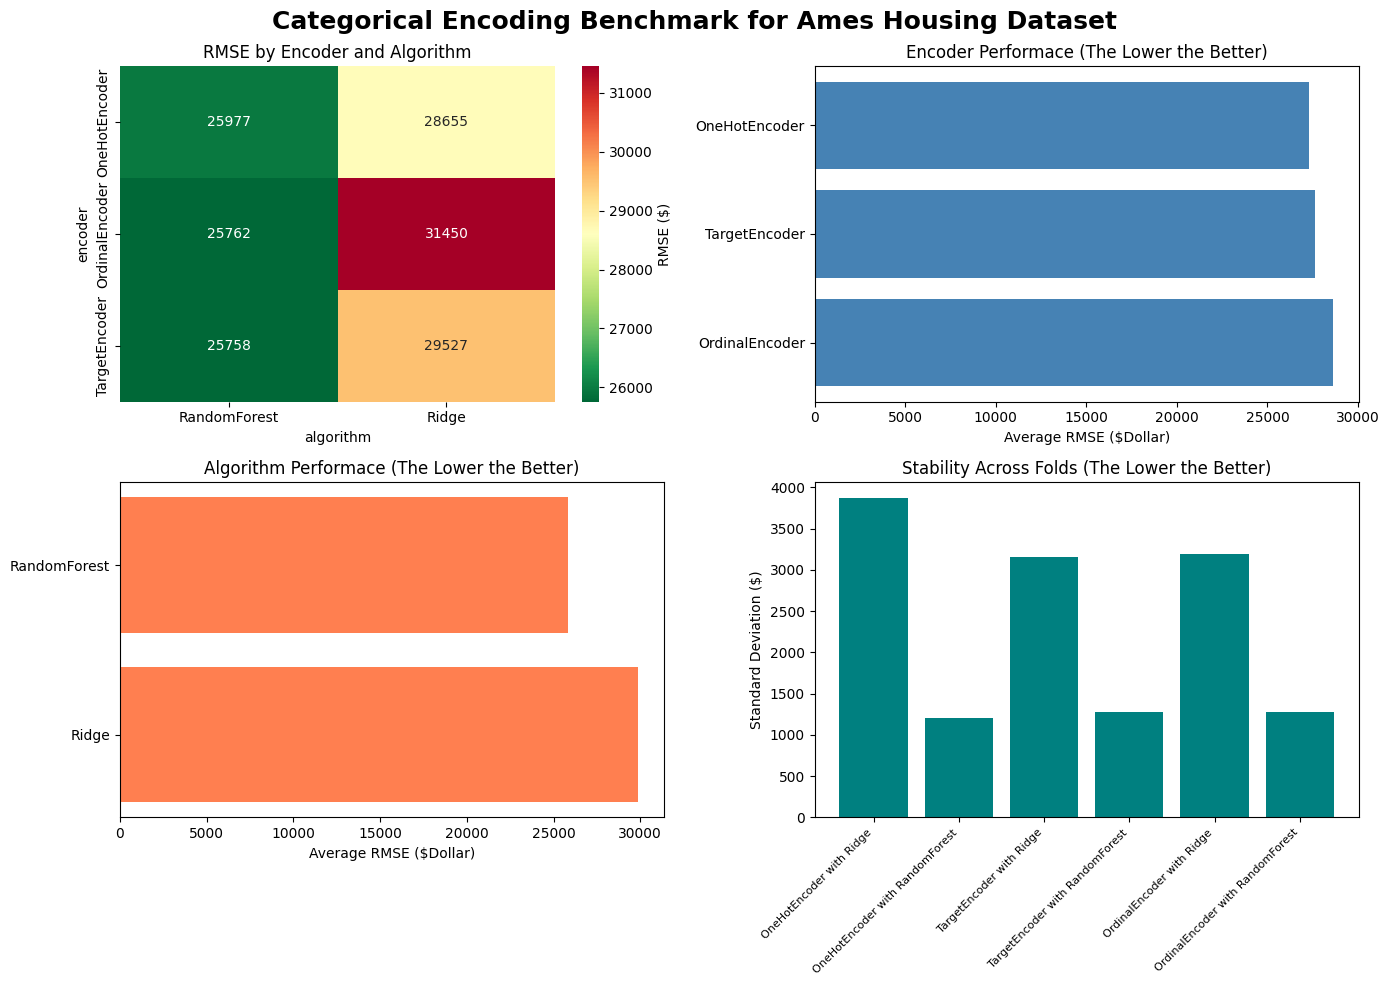


Results saved to baseline_test_results.csv


In [5]:
# ## Run Baseline Test

if X is not None:
    # Initialize and run baseline
    baseline = EncodingBenchmark(random_state=42)
    
    # Run the test
    results = baseline.run_baseline_test(X, y, cat_columns, num_columns)
    
    # Analyze results
    analysis = baseline.analyse_results(results)

    # visualize results
    baseline.visualize_results(results)

    
    # Save results
    results.to_csv('../results/baseline_test_results.csv', index=False)
    print(f"\nResults saved to baseline_test_results.csv")